In [88]:
import os
import json

import numpy as np
import pandas as pd
from scipy.sparse import hstack
import string
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import xgboost as xgb

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
seed = 291

In [3]:
data_dir = "../data/runtime"
data = pd.read_csv(os.path.join(data_dir, "proccessed-data.csv"))
data.head()

,query,runtime (ms),query_complexity,runtime_boolean,table_size
0,select distinct coursealias0advisory_requireme...,8.092165,1,1,11453
1,select distinct coursealias0department coursea...,0.772238,1,0,11531
2,select distinct coursealias0department coursea...,0.530958,1,0,11531
3,select count 0 from course as coursealias0 cou...,92.988014,0,1,326457
4,select distinct coursealias0department coursea...,1.093864,1,0,23060


In [4]:
labels = data['runtime_boolean']

In [5]:
x_basic = data[['query_complexity', 'table_size']].copy()

## BoW (CountVectorizer)

In [6]:
bow_features = data['query'].copy()
vectorizer = CountVectorizer()
bow_features = vectorizer.fit_transform(bow_features)
additional_features = data[['query_complexity', 'table_size']].values
x_bow = hstack([bow_features, additional_features])
print(x_bow.shape)

(1799, 1439)


## Word2Vec

In [7]:
w2v_features = data['query'].apply(lambda x: x.lower().split())
translator = str.maketrans('', '', string.punctuation)
w2v_features = [[word for word in query if word.translate(translator) != ''] for query in w2v_features]

In [8]:
word2vec_model = Word2Vec(w2v_features, window=5, min_count=1, workers=4)

In [9]:
word_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.key_to_index.keys()}
w2v_mean_features = np.array([np.mean([word_embeddings[word] for word in query], axis=0) for query in w2v_features])
x_w2v = np.hstack([w2v_mean_features, additional_features])
print(x_w2v.shape)

(1799, 102)


In [10]:
def train_valid_test_split(X, y, test_size=0.15, valid_size=0.15, random_state=seed):
    valid_perc = valid_size / (1. - test_size)
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=valid_perc, random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test, X_trainval, y_trainval

In [11]:
# train, validation, test split (70:15:15)
basic_X_train, basic_y_train, basic_X_val, basic_y_val, basic_X_test, basic_y_test, basic_X_trainval, basic_y_trainval= train_valid_test_split(x_basic, labels)
bow_X_train, bow_y_train, bow_X_val, bow_y_val, bow_X_test, bow_y_test, bow_X_trainval, bow_y_trainval= train_valid_test_split(x_bow, labels)
w2v_X_train, w2v_y_train, w2v_X_val, w2v_y_val, w2v_X_test, w2v_y_test, w2v_X_trainval, w2v_y_trainval = train_valid_test_split(x_w2v, labels)

In [12]:
# normalize trainval data
basic_trainval_scaler = MinMaxScaler()
norm_basic_X_trainval = basic_trainval_scaler.fit_transform(basic_X_trainval)
norm_basic_X_test = basic_trainval_scaler.fit_transform(basic_X_test)

bow_trainval_scaler = MinMaxScaler()
norm_bow_X_trainval = bow_trainval_scaler.fit_transform(bow_X_trainval.toarray())
norm_bow_X_test = bow_trainval_scaler.fit_transform(bow_X_test.toarray())

w2v_trainval_scaler = MinMaxScaler()
norm_w2v_X_trainval = w2v_trainval_scaler.fit_transform(w2v_X_trainval)
norm_w2v_X_test = w2v_trainval_scaler.fit_transform(w2v_X_test)

## SVM

In [13]:
svc_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

In [14]:
svc = SVC(max_iter=5000)
basic_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_svc_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_svc_clf.best_estimator_)
print(basic_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=1000, degree=2, kernel='linear', max_iter=5000)
0.8116339869281045


In [15]:
svc = SVC()
bow_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_svc_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_svc_clf.best_estimator_)
print(bow_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=10, degree=2)
0.887493839065681


In [16]:
svc = SVC()
w2v_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_svc_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_svc_clf.best_estimator_)
print(w2v_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=1000, degree=2, kernel='poly')
0.8783199399978571


## Random Forest

In [17]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [18]:
rf = RandomForestClassifier()
basic_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_rf_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_rf_clf.best_estimator_)
print(basic_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=50)
0.8822565091610415


In [19]:
rf = RandomForestClassifier()
bow_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_rf_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_rf_clf.best_estimator_)
print(bow_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)
0.8861887924568734


In [20]:
rf = RandomForestClassifier()
w2v_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_rf_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_rf_clf.best_estimator_)
print(w2v_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(criterion='entropy', max_depth=20)
0.8881538626379513


## XGBoost

In [21]:
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [22]:
xgbc = xgb.XGBClassifier()
basic_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_xgb_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_xgb_clf.best_estimator_)
print(basic_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8672174006214508


In [23]:
xgbc = xgb.XGBClassifier()
bow_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_xgb_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_xgb_clf.best_estimator_)
print(bow_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8959905710918248


In [24]:
xgbc = xgb.XGBClassifier()
w2v_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_xgb_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_xgb_clf.best_estimator_)
print(w2v_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8887903139397835


## MLP

In [30]:
mlp_params = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50, 25)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'early_stopping': [True, False],
    'max_iter': [200, 400, 600],
    'batch_size': [64]
}

In [31]:
mlp = MLPClassifier(random_state=291)
basic_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_mlp_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_mlp_clf.best_estimator_)
print(basic_mlp_clf.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

MLPClassifier(batch_size=64, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, random_state=291)
0.8201328618879247


In [32]:
mlp = MLPClassifier(random_state=291)
bow_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_mlp_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_mlp_clf.best_estimator_)
print(bow_mlp_clf.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

MLPClassifier(batch_size=64, hidden_layer_sizes=(100, 50, 25), random_state=291,
              solver='sgd')
0.8822586520947177


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
mlp = MLPClassifier(random_state=291)
w2v_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_mlp_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_mlp_clf.best_estimator_)
print(w2v_mlp_clf.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kevkev/anaconda3/lib/pyth

MLPClassifier(activation='tanh', batch_size=64,
              hidden_layer_sizes=(100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0.1, max_iter=600, random_state=291,
              solver='sgd')
0.858045644487303


In [ ]:
# Evaluate on Test Set

In [41]:
def evaluate(test_X, test_y, model, output_dict=True):
    y_pred = model.predict(test_X)
    report = classification_report(test_y, y_pred, output_dict=output_dict)
    return model, report

In [45]:
# SVM
_, basic_svc_res = evaluate(norm_basic_X_test, basic_y_test, basic_svc_clf.best_estimator_)
print('SVC Basic')
print(basic_svc_res['accuracy'])

_, bow_svc_res = evaluate(norm_bow_X_test, bow_y_test, bow_svc_clf.best_estimator_)
print('SVC BOW')
print(bow_svc_res['accuracy'])

_, w2v_svc_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_svc_clf.best_estimator_)
print('SVC W2V')
print(w2v_svc_res['accuracy'])

SVC Basic
0.8333333333333334
SVC BOW
0.9037037037037037
SVC W2V
0.2814814814814815


In [48]:
# RF
_, basic_rf_res = evaluate(norm_basic_X_test, basic_y_test, basic_rf_clf.best_estimator_)
print('RF Basic')
print(basic_rf_res['accuracy'])

_, bow_rf_res = evaluate(norm_bow_X_test, bow_y_test, bow_rf_clf.best_estimator_)
print('RF BOW')
print(bow_rf_res['accuracy'])

_, w2v_rf_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_rf_clf.best_estimator_)
print('RF W2V')
print(w2v_rf_res['accuracy'])

RF Basic
0.7407407407407407
RF BOW
0.8888888888888888
RF W2V
0.8407407407407408


In [49]:
# XGB
_, basic_xgb_res = evaluate(norm_basic_X_test, basic_y_test, basic_xgb_clf.best_estimator_)
print('XGB Basic')
print(basic_xgb_res['accuracy'])

_, bow_xgb_res = evaluate(norm_bow_X_test, bow_y_test, bow_xgb_clf.best_estimator_)
print('XGB BOW')
print(bow_xgb_res['accuracy'])

_, w2v_xgb_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_xgb_clf.best_estimator_)
print('XGB W2V')
print(w2v_xgb_res['accuracy'])

XGB Basic
0.7666666666666667
XGB BOW
0.8851851851851852
XGB W2V
0.837037037037037


In [50]:
# MLP
_, basic_mlp_res = evaluate(norm_basic_X_test, basic_y_test, basic_mlp_clf.best_estimator_)
print('MLP Basic')
print(basic_mlp_res['accuracy'])

_, bow_mlp_res = evaluate(norm_bow_X_test, bow_y_test, bow_mlp_clf.best_estimator_)
print('MLP BOW')
print(bow_mlp_res['accuracy'])

_, w2v_mlp_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_mlp_clf.best_estimator_)
print('MLP W2V')
print(w2v_mlp_res['accuracy'])

MLP Basic
0.7962962962962963
MLP BOW
0.9037037037037037
MLP W2V
0.7814814814814814


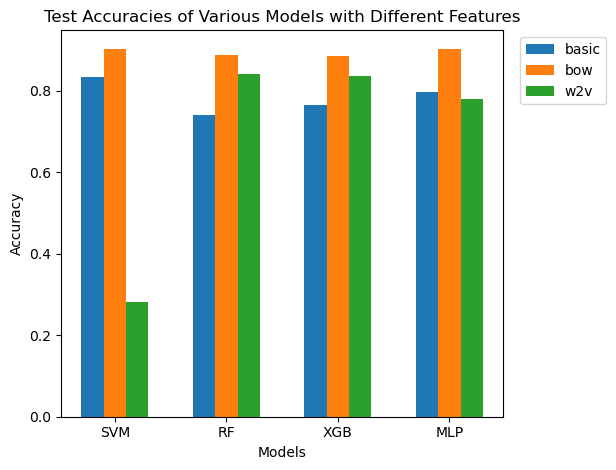

In [125]:
# Plot Results
models = ['SVM', 'RF', 'XGB', 'MLP']
features = ['basic', 'bow', 'w2v']
all_accuracy = [
    [0.8333333333333334, 0.9037037037037037, 0.2814814814814815],  # Accuracies for SVC
    [0.7407407407407407, 0.8888888888888888, 0.8407407407407408],  # Accuracies for RF
    [0.7666666666666667, 0.8851851851851852, 0.837037037037037],   # Accuracies for XGB
    [0.7962962962962963, 0.9037037037037037, 0.7814814814814814]   # Accuracies for MLP
]

n_models = len(models)
n_features = len(features)

bar_width = 0.2
index = np.arange(n_models)

fig, ax = plt.subplots()

for i in range(n_features):
    plt.bar(index + i * bar_width, [acc[i] for acc in all_accuracy], bar_width, label=features[i])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracies of Various Models with Different Features')
plt.xticks(index + bar_width * (n_features - 1) / 2, models)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout() 
plt.savefig('test_accuracies.png')

plt.show()

In [83]:
# Most important features given by RF
rf_bow_feature_importance = bow_rf_clf.best_estimator_.feature_importances_
sorted_feature_importance = np.argsort(-np.abs(rf_bow_feature_importance))
bow_full_feature_names = np.concatenate((vectorizer.get_feature_names_out(), ['query_complexity', 'table_size']))
k = 20
print(f'Top {k} most important features')
print(bow_full_feature_names[sorted_feature_importance[:k]])

Top 20 most important features
['table_size' 'and' 'as' 'moviealias0' 'moviealias0title'
 'actoralias0name' 'moviealias0mid' 'actor' 'course_offeringalias0'
 'actoralias0' 'coursealias0' 'course' 'airport_servicealias1city_code'
 'program_course' 'course_offeringalias0course_id' 'semesteralias0'
 'course_offering' 'movie' 'moviealias0release_year' 'city']


In [ ]:
# Test on Yelp Dataset

In [103]:
yelp = pd.read_csv(os.path.join(data_dir, 'query-runtime-yelp.csv'))
yelp.head()

,query,runtime (ms),db,engine
0,SELECT BUSINESSalias0.NAME FROM BUSINESS AS BU...,55.692196,yelp,mysql
1,SELECT BUSINESSalias0.NAME FROM BUSINESS AS BU...,34.402132,yelp,mysql
2,SELECT USERalias0.USER_ID FROM USER AS USERali...,101.726055,yelp,mysql
3,SELECT BUSINESSalias0.STATE FROM BUSINESS AS B...,12.228251,yelp,mysql
4,SELECT BUSINESSalias0.CITY FROM BUSINESS AS BU...,45.446873,yelp,mysql


In [104]:
yelp['query'] = yelp['query'].str.lower()
complex_keywords = ["join", "distinct", "group by", "count", "order by"]

def check_query_complexity(query):
    words = query.split()
    return int(any(keyword in words for keyword in complex_keywords))

yelp["query_complexity"] = yelp["query"].apply(check_query_complexity)

threshold = 2.7047347051217843
yelp['runtime_boolean'] = (yelp['runtime (ms)'] >= threshold).astype(int)
counts = yelp['runtime_boolean'].value_counts()
print(counts)

runtime_boolean
1    120
Name: count, dtype: int64


In [114]:
with open("../data/table_sizes.json", 'r') as json_file:
    table_names = json.load(json_file)

In [107]:
def compute_table_size(row, table_names):
    query = row['query']
    db = row['db']
    words = query.split()
    count = 0
    for word in words:
        if word in table_names[db]:
            count += table_names[db][word]
    return count

yelp['table_size'] = yelp.apply(lambda row: compute_table_size(row, table_names), axis=1)

In [109]:
del yelp['engine']
del yelp['db']

In [112]:
yelp_x_basic = yelp[['query_complexity', 'table_size']].copy()

yelp_bow_features = vectorizer.transform(yelp['query'].copy())
yelp_additional_features = yelp[['query_complexity', 'table_size']].values
yelp_x_bow = hstack([yelp_bow_features, yelp_additional_features])
print(yelp_x_bow.shape)

(120, 1439)


In [113]:
yelp_labels = yelp['runtime_boolean']

In [135]:
# Nomalize using the original scaler
yelp_norm_basic_X = basic_trainval_scaler.transform(yelp_x_basic)
yelp_norm_bow_X = bow_trainval_scaler.transform(yelp_x_bow.toarray())

In [136]:
_, yelp_basic_res = evaluate(yelp_norm_basic_X, yelp_labels, basic_rf_clf.best_estimator_)
print('Yelp RF Basic')
print(yelp_basic_res['accuracy'])

_, yelp_bow_res = evaluate(yelp_norm_bow_X, yelp_labels, bow_rf_clf.best_estimator_)
print('Yelp RF BOW')
print(yelp_bow_res['accuracy'])

Yelp RF Basic
0.975
Yelp RF BOW
0.0


/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevkev/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kevkev/anaconda3/lib/python3.11/site-packa